In [1]:
import numpy as np
import enum
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

In [2]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

In [3]:
def P0TModel(t,ti,ri,method):
    #rInterp = method(ti,ri)
    if t >= ti[-1]:
        r = ri[-1]
    elif t <= ti[0]:
        r = ri[0]
    elif t > ti[0] and t < ti[-1]:
        r = method(t,ti,ri)
        
    return np.exp(-r*t)

In [4]:
def IRSwap(CP,notional,K,t,Ti,Tm,n,P0T):
    #CP = type of Swap Payer/Receiver = PAYER
    #Notional =  amount = 1
    #K = Existing market rate for Swap under consideration = 0.04/100.0
    #t = t0 = 0
    #Ti = Initial time may be = t0 = 0
    #Tm = maturity of each swap component = 1 
    #n = Number of intervals considered = 4 * Tm
    #P0T = function to find present value
    ti_grid = np.linspace(Ti,Tm,int(n))
    tau = ti_grid[1] - ti_grid[0]
    
    #overwrite Ti if t > Ti, this will never be true
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0:
        Ti = prevTi[-1]
        
    # Now we need to handle the case when some payments are already done, this condition will never get satisfy,
    #As starting time is to(t) = 0.
    ti_grid = ti_grid[np.where(ti_grid>t)]
    
    P_t_Ti = P0T(Ti)
    P_t_Tm = P0T(Tm)
    
    temp = 0
    #below will calculate ZCB for all value till ti which will be from between Ti and Tm, second part of swap calculation
    for idx, ti in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P0T(ti)
            
    if CP == OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * temp - (P_t_Ti - P_t_Tm)
    
    return swap * notional

In [5]:
def YieldCurve(instruments, maturities, r0, method, tol):
    r0 = deepcopy(r0)
    ri = MultivariateNewtonRaphson(r0,maturities,instruments,method,tol)
    return ri

In [6]:
def MultivariateNewtonRaphson(ri,ti,instruments,method,tol):
    err = 10e10
    idx = 0
    while err>tol and idx < 100:
        idx += 1
        values = EvaluateInstruments(ti,ri,instruments,method)
        J = Jacobian(ti,ri,instruments,method)
        J_inv = np.linalg.inv(J)
        err = - np.dot(J_inv, values)
        ri[0:] = ri[0:] + err
        err = np.linalg.norm(err)
        #print('index in the loop is' , idx, 'Error is', err)
    return ri

In [7]:
def Jacobian(ti,ri,instruments,method):
    eps = 1e-05
    swap_num = len(ri)
    J = np.zeros([swap_num, swap_num]) #8*8
    val = EvaluateInstruments(ti,ri,instruments,method)
    ri_up = deepcopy(ri)
    #print(f'{ri_up} ye he')
    for j in range(len(ri)):
        ri_up[j] = ri[j] + eps
        val_up = EvaluateInstruments(ti,ri_up,instruments, method)
        ri_up[j] = ri[j]
        dv = (val_up - val) / eps
        J[:,j] = dv[:]
    return J

In [8]:
def EvaluateInstruments(ti,ri,instruments,method):
    def P0Ttemp(t):
        P0Ttemp = P0TModel(t,ti,ri,method)
        return P0Ttemp
    
    val = np.zeros(len(instruments))
    for i in range(len(instruments)):
        val[i] = instruments[i](P0Ttemp)
    return val

In [9]:
def linear_interpolation(t,ti,ri):
    def interpolator(t):
        return np.interp(t,ti,ri)
    
    interpolator = interpolator(t)
    return interpolator

In [10]:
def cubic_interpolation(t,ti,ri):
    interpolator = interp1d(ti,ri,kind = 'cubic')
    return interpolator(t)

In [11]:
def quadratic_interpolation(t,ti,ri):
    interpolator = interp1d(ti,ri,kind = 'quadratic')
    return interpolator(t)

In [12]:
def BuildYieldCurve(K,mat):
    #Convergence tolerence
    tol = 1.0e-15
    
    #Initial guess
    r0 = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])
    
    method = linear_interpolation
    
    def swap1(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[0],0.0,0.0,mat[0],4*mat[0],P0T)
    def swap2(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[1],0.0,0.0,mat[1],4*mat[1],P0T)
    def swap3(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[2],0.0,0.0,mat[2],4*mat[2],P0T)
    def swap4(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[3],0.0,0.0,mat[3],4*mat[3],P0T)
    def swap5(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[4],0.0,0.0,mat[4],4*mat[4],P0T)
    def swap6(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[5],0.0,0.0,mat[5],4*mat[5],P0T)
    def swap7(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[6],0.0,0.0,mat[6],4*mat[6],P0T)
    def swap8(P0T):
        return IRSwap(OptionTypeSwap.PAYER,1,K[7],0.0,0.0,mat[7],4*mat[7],P0T)
        
    instruments = [swap1,swap2,swap3,swap4,swap5,swap6,swap7,swap8]
    
    # determine optimal spine points
    ri = YieldCurve(instruments, mat, r0, method, tol)
    #print('\n Spine points are',ri,'\n')
    
    def P0T(t):
        return P0TModel(t,mat,ri,method)
    
    return P0T, instruments

In [13]:
def Portfolio(P0T):
    #IRSwap(CP,           notional,          K,   t,   Ti,  Tm,   n,      P0T):
    value = IRSwap(OptionTypeSwap.RECEIVER,1000000,0.02,0.0, 0.0,  20,  20,  P0T) +\
            IRSwap(OptionTypeSwap.PAYER, 500000,   0.01,0.0, 0.0,  10,  20,  P0T) +\
            IRSwap(OptionTypeSwap.RECEIVER,25000,0.02,0.0, 0.0,  30,  60,  P0T) +\
            IRSwap(OptionTypeSwap.PAYER,74000,0.005,0.0, 0.0,  5,  10,  P0T) +\
            IRSwap(OptionTypeSwap.RECEIVER,254000,0.032,0.0, 0.0,  15,  10,  P0T) +\
            IRSwap(OptionTypeSwap.RECEIVER,854000,0.01,0.0, 0.0,  7,  20,  P0T) +\
            IRSwap(OptionTypeSwap.PAYER,350000,0.028,0.0, 0.0,  10,  20,  P0T) +\
            IRSwap(OptionTypeSwap.PAYER,1000000,-0.01,0.0, 0.0,  5,  20,  P0T) +\
            IRSwap(OptionTypeSwap.RECEIVER,1000000,0.01,0.0, 0.0,  14,  20,  P0T) +\
            IRSwap(OptionTypeSwap.PAYER,1000000,0.03,0.0, 0.0,  2,  4,  P0T) 

    return value

In [14]:
def finalCode():
    #Curves from market
    marketdataXLS = pd.read_excel('MrktData.xlsx')
    
    #Divide by 100 to express in %
    marketData = np.array(marketdataXLS) / 100
    
    #Building up 1D scenarios
    shape = np.shape(marketData)
    NoOfScen = shape[0]
    NoOfInsts = shape[1]
    
    Scenarios = np.zeros([NoOfScen-1, NoOfInsts])
    
    for i in range(0, NoOfScen-1):
        for j in range(0, NoOfInsts):
            Scenarios[i,j] = marketData[i+1,j] - marketData[i,j]
            
    # Construct instruments for TODAY's curve
    Swaps_mrkt   = np.array([0.08,0.2,0.4,0.77,1.07,1.29,1.82,1.9]) / 100
    mat = np.array([1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0])
    
    #Given market quotes for swaps and scenarios we generate now "shocked" yield curves
    Swaps_mrkt_shocked = np.zeros([NoOfScen-1, NoOfInsts])
    for i in range(0, NoOfScen-1):
        for j in range(0,NoOfInsts):
            Swaps_mrkt_shocked[i,j] = Swaps_mrkt[j] + Scenarios[i,j]
            
    #For every shocked market scenarios build a yield curve
    YC_for_VaR = []
    
    for i in range(0, NoOfScen-1):
        P0T, instruments = BuildYieldCurve(Swaps_mrkt_shocked[i,:], mat)
        YC_for_VaR.append(P0T)
        print('Scenario number', i, ' out of ', NoOfScen-1)
    #print(YC_for_VaR)    
    #For every shocked market scenario we build the portfolio of interest rate derivatives
    PortfolioPV = np.zeros([NoOfScen-1])
    for i in range(0, NoOfScen-1):
        PortfolioPV[i] = Portfolio(YC_for_VaR[i])
        
    # Current Yield curve
    YC_today,insts = BuildYieldCurve(Swaps_mrkt,mat)
    print('Current Portfolio PV is ', Portfolio(YC_today))
    
    # Histograms and Var Calculatiosn
    plt.figure(1)
    plt.grid()
    plt.hist(PortfolioPV,20)
    
    # VaR calculation
    alpha = 0.05
    HVaR_estimate = np.quantile(PortfolioPV,alpha)
    print('(H)VaR for alpha = ', alpha, ' is equal to=', HVaR_estimate)
    
    # Expected shortfal
    condLosses = PortfolioPV[PortfolioPV < HVaR_estimate]
    print('P&L which < VaR_alpha =',condLosses)
    ES = np.mean(condLosses)
    
    print('Expected shortfal = ', ES)
    
    plt.plot(HVaR_estimate,0,'or')
    plt.plot(ES,0,'ok')
    plt.legend(['VaR','ES','P&L'])
    
    return 0.0

Scenario number 0  out of  165
Scenario number 1  out of  165
Scenario number 2  out of  165
Scenario number 3  out of  165
Scenario number 4  out of  165
Scenario number 5  out of  165
Scenario number 6  out of  165
Scenario number 7  out of  165
Scenario number 8  out of  165
Scenario number 9  out of  165
Scenario number 10  out of  165
Scenario number 11  out of  165
Scenario number 12  out of  165
Scenario number 13  out of  165
Scenario number 14  out of  165
Scenario number 15  out of  165
Scenario number 16  out of  165
Scenario number 17  out of  165
Scenario number 18  out of  165
Scenario number 19  out of  165
Scenario number 20  out of  165
Scenario number 21  out of  165
Scenario number 22  out of  165
Scenario number 23  out of  165
Scenario number 24  out of  165
Scenario number 25  out of  165
Scenario number 26  out of  165
Scenario number 27  out of  165
Scenario number 28  out of  165
Scenario number 29  out of  165
Scenario number 30  out of  165
Scenario number 31

0.0

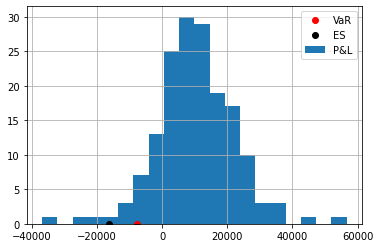

In [15]:
finalCode()